In [2]:
pip install rembg


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.1 MB/s eta 0:00:00


In [ ]:
pip install joblib


In [51]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from rembg import remove
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

dataset = 'dataset-sampah3'
kategori = ['besi', 'kertas atau kardus', 'plastik']
label = {kategori: idx for idx, kategori in enumerate(kategori)}


Gambar acak dari besi:


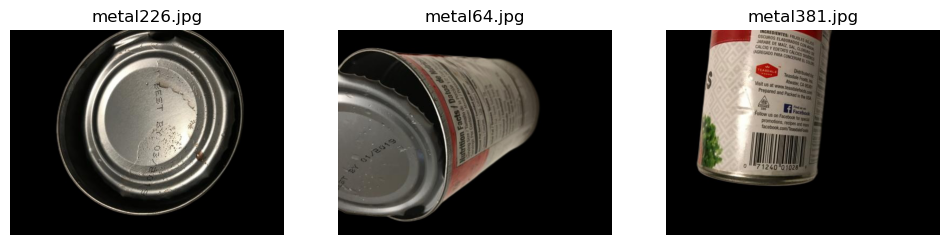


Gambar acak dari kertas atau kardus:


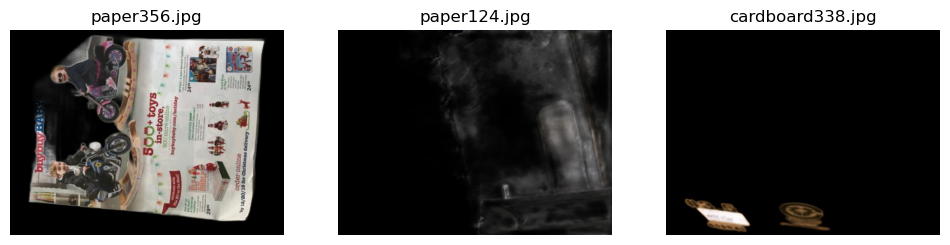


Gambar acak dari plastik:


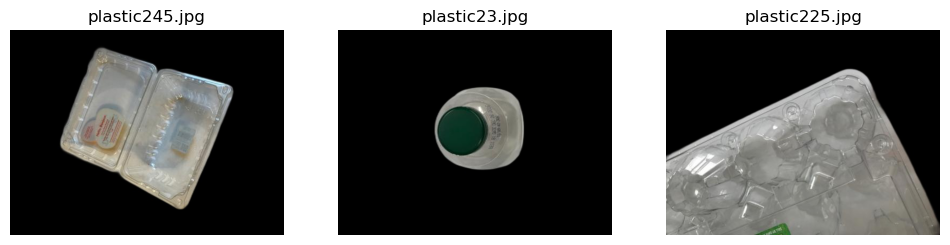

In [52]:
def tampilkan_gambar_acak(kategori, num_images_per_category=3):
    for kategori_item in kategori:
        category_path = os.path.join(dataset, kategori_item)
        image_files = os.listdir(category_path)
        random_images = random.sample(image_files, num_images_per_category)
        print(f"\nGambar acak dari {kategori_item}:")
        plt.figure(figsize=(num_images_per_category * 4, 4))
        for i, image_file in enumerate(random_images):
            image_path = os.path.join(category_path, image_file)
            image = plt.imread(image_path)
            plt.subplot(1, num_images_per_category, i+1)
            plt.imshow(image)
            plt.title(image_file)
            plt.axis('off')
        plt.show()

tampilkan_gambar_acak(kategori)

In [53]:
# Fungsi untuk mendapatkan label (indeks kelas) dari nama folder
def dapatkan_label(categories):
    labels = {}
    for i, category in enumerate(categories):
        labels[category] = i
    return labels

# Dapatkan label untuk setiap kelas
labels = dapatkan_label(kategori)

# Fungsi untuk mendapatkan label dan path file untuk semua gambar
def dapatkan_label_dan_path(dataset, labels):
    X, y = [], []
    for category, label in labels.items():
        category_path = os.path.join(dataset, category)
        if os.path.isdir(category_path):  # Pastikan itu adalah direktori
            image_files = os.listdir(category_path)
            for image_file in image_files:
                image_path = os.path.join(category_path, image_file)
                X.append(image_path)
                y.append(label)
    return X, y

X, y = dapatkan_label_dan_path(dataset, labels)

In [21]:
# Tampilkan mapping deskripsi mengenai label kelas yang telah diencode
print("\nMapping deskripsi label kelas:")
for category, label in labels.items():
    print(f"{label}: {category}")


Mapping deskripsi label kelas:
0: besi
1: kertas atau kardus
2: plastik


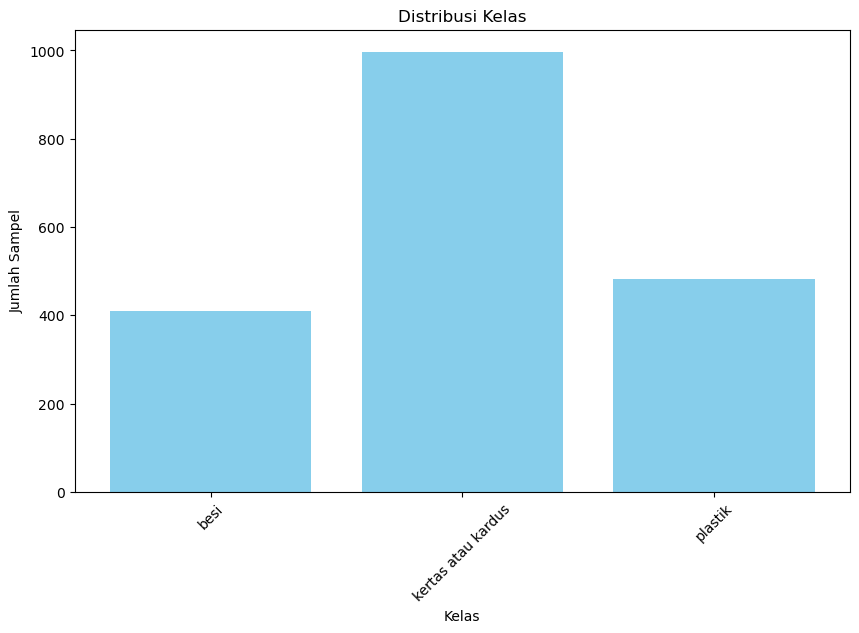

In [22]:
def tampilkan_distribusi_kelas(y, categories):
    class_counts = np.bincount(y)
    plt.figure(figsize=(10, 6))
    plt.bar(categories, class_counts, color='skyblue')
    plt.title('Distribusi Kelas')
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Sampel')
    plt.xticks(rotation=45)
    plt.show()


tampilkan_distribusi_kelas(y, kategori)

In [6]:
import os
import cv2
from collections import defaultdict

ukuran_gambar = defaultdict(int)

def dapatkan_ukuran_gambar(dataset):
    for category in os.listdir(dataset):
        category_path = os.path.join(dataset, category)
        if os.path.isdir(category_path):  
            for image_file in os.listdir(category_path):
                image_path = os.path.join(category_path, image_file)
                image = cv2.imread(image_path)
                if image is not None:
                    height, width, _ = image.shape
                    size_str = f'{width}x{height}'
                    ukuran_gambar[size_str] += 1
    return ukuran_gambar

dataset = 'dataset-sampah3'

ukuran_gambar = dapatkan_ukuran_gambar(dataset)

for size, count in ukuran_gambar.items():
    print(f'Ukuran: {size}, Jumlah: {count}')

total_data = sum(ukuran_gambar.values())
print(f'Total jumlah data: {total_data}')

Ukuran: 512x384, Jumlah: 1889
Total jumlah data: 1889


In [54]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    # Remove background
    # image_no_bg = remove(image)
    # Normalize image (rescale pixel values to range [0, 1])
    normalized_image = image / 255.0
    return normalized_image

In [55]:
X_preprocessed = [preprocess_image(image_path) for image_path in X]

In [56]:
# Convert list ke numpy array
X_preprocessed = np.array(X_preprocessed)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [58]:
print(f"Original feature dimensions: {X_train.shape}")

Original feature dimensions: (1511, 384, 512, 3)


In [59]:
def optimal_pca_components(X, variance_threshold=0.95):
    pca = PCA().fit(X)
    cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_explained_variance >= variance_threshold) + 1
    return n_components

X_train_pca = []
X_test_pca = []

for i in range(3): 
    # Flatten pada tiap layer
    X_train_layer = X_train[:, :, :, i].reshape(len(X_train), -1)
    X_test_layer = X_test[:, :, :, i].reshape(len(X_test), -1)
    
    n_components = optimal_pca_components(X_train_layer)
    print(f"Optimal number of PCA components for layer {i}: {n_components}")
    
    pca = PCA(n_components=n_components)
    X_train_layer_pca = pca.fit_transform(X_train_layer)
    X_test_layer_pca = pca.transform(X_test_layer)
    
    X_train_pca.append(X_train_layer_pca)
    X_test_pca.append(X_test_layer_pca)

X_train_pca = np.hstack(X_train_pca)
X_test_pca = np.hstack(X_test_pca)

print(f"Original feature dimensions: {X_train.shape}")
print(f"Dimensions after PCA: {X_train_pca.shape}")

Optimal number of PCA components for layer 0: 383
Optimal number of PCA components for layer 1: 381
Optimal number of PCA components for layer 2: 365
Original feature dimensions: (1511, 384, 512, 3)
Dimensions after PCA: (1511, 1129)


In [13]:
import joblib
joblib.dump(pca, 'model_pca_svm.pkl')

['model_pca_svm.pkl']

# Kernel Linear

In [60]:
svm = SVC(kernel='linear')
svm.fit(X_train_pca, y_train)

SVC(kernel='linear')

In [61]:
y_pred = svm.predict(X_test_pca)

print(classification_report(y_test, y_pred, target_names=kategori))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

                    precision    recall  f1-score   support

              besi       0.29      0.37      0.33        82
kertas atau kardus       0.61      0.59      0.60       191
           plastik       0.45      0.39      0.42       105

          accuracy                           0.49       378
         macro avg       0.45      0.45      0.45       378
      weighted avg       0.50      0.49      0.49       378

Accuracy: 0.48677248677248675


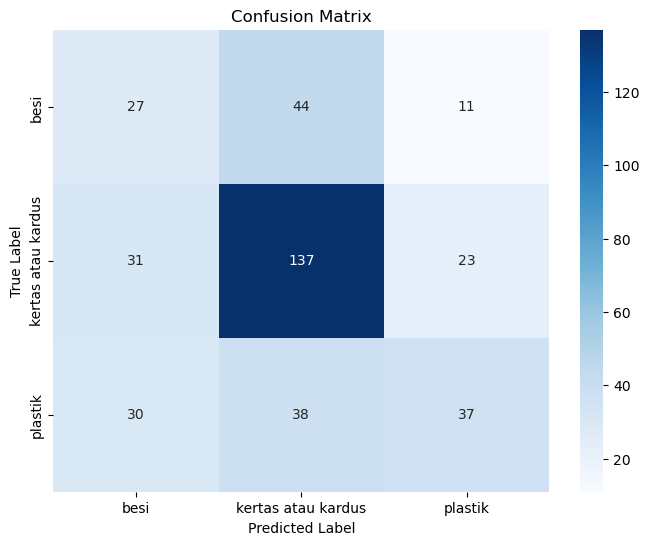

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=kategori, yticklabels=kategori)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [21]:
joblib.dump(svm, 'model_svm_linear.pkl')

['model_svm_linear.pkl']

# Kernel RBF

In [62]:
svmrbf = SVC(kernel='rbf')
svmrbf.fit(X_train_pca, y_train)

SVC()

In [63]:
y_pred = svmrbf.predict(X_test_pca)

In [64]:
print(classification_report(y_test, y_pred, target_names=kategori))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

                    precision    recall  f1-score   support

              besi       0.64      0.48      0.55        82
kertas atau kardus       0.69      0.87      0.77       191
           plastik       0.67      0.48      0.56       105

          accuracy                           0.68       378
         macro avg       0.67      0.61      0.62       378
      weighted avg       0.67      0.68      0.66       378

Accuracy: 0.6772486772486772


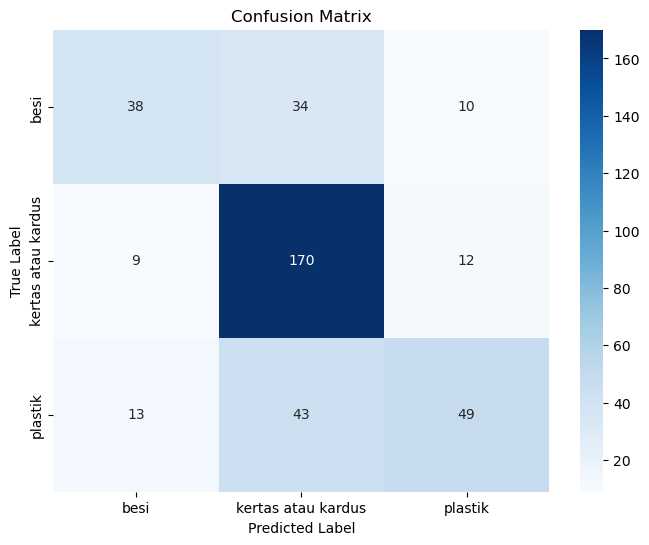

In [35]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=kategori, yticklabels=kategori)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [28]:
joblib.dump(svm, 'model_svm_rbf.pkl')

['model_svm_rbf.pkl']

# Objek dectection INPUT USER

Masukkan jalur file gambar: /Users/ferdirj/Downloads/testdataa.jpg


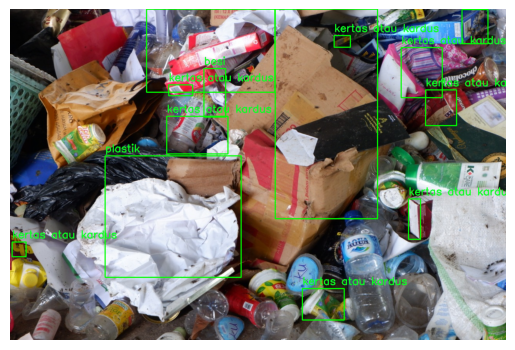

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import joblib

# Fungsi untuk mendapatkan label (indeks kelas) dari nama folder
def mendapatkan_label(kategori):
    labels = {}
    for i, kategori in enumerate(kategori):
        labels[kategori] = i
    return labels


kategori = ['besi', 'kertas atau kardus', 'plastik']
label = mendapatkan_label(kategori)

# load model
svm = joblib.load('model_svm_rbf.pkl')
pca = joblib.load('model_pca_svm.pkl')

def pilih_gambar():
    while True:
        image_path = input("Masukkan jalur file gambar: ")
        if os.path.isfile(image_path):
            return image_path
        else:
            print("Jalur file tidak valid. Harap masukkan jalur yang valid.")

def pra_proses_gambar(image_path, ukuran_target):
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, ukuran_target)
    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    edges = cv2.bitwise_not(edges)
    _, mask = cv2.threshold(edges, 0, 255, cv2.THRESH_BINARY)
    # Terapkan mask ke gambar asli
    result = cv2.bitwise_and(resized_image, resized_image, mask=mask)
    return result

def deteksi_objek(image_path, luas_contour_min=500):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    # Temukan kontur
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Inisialisasi list untuk bounding box 
    boxes = []
    # membuat bounding box di sekitar objek yang terdeteksi
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > luas_contour_min:
            x, y, w, h = cv2.boundingRect(contour)
            boxes.append((x, y, w, h))
    return boxes

def prediksi_kategori_sampah(image_path, model, model_pca, ukuran_target=(384, 512)):
    preprocessed_image = pra_proses_gambar(image_path, ukuran_target)
    
    # Normalisasi gambar (rescale nilai piksel ke rentang [0, 1])
    normalized_image = preprocessed_image / 255.0
    
    # PCA tiap layer
    X = []
    for i in range(3):  # RGB
        layer = normalized_image[:, :, i].flatten()
        X_layer_pca = model_pca.transform([layer])
        X.append(X_layer_pca)
    X_pca = np.hstack(X)
    
    # Prediksi kategori sampah
    prediction = model.predict(X_pca)
    predicted_category = kategori[prediction[0]]
    return predicted_category

def prediksi_kategori_sampah_dengan_deteksi(image_path, model, model_pca, ukuran_target=(384, 512)):
    # Deteksi objek dalam gambar
    boxes = deteksi_objek(image_path)

    image = cv2.imread(image_path)

    # Iterasi kotak yang terdeteksi
    for (x, y, w, h) in boxes:
        # Potong objek yang terdeteksi dari gambar
        cropped_image = image[y:y+h, x:x+w]
        
        # Simpan gambar yang dipotong sementara untuk memprediksi kategorinya
        temporary_path = 'temp.jpg'
        cv2.imwrite(temporary_path, cropped_image)
        
        # Prediksi kategori dari gambar yang dipotong
        predicted_category = prediksi_kategori_sampah(temporary_path, model, model_pca, ukuran_target)
        
        # Gambar kotak pembatas dan label pada gambar asli
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(image, predicted_category, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        
        os.remove(temporary_path)
    
    # Tampilkan citra dengan bounding box dan label
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

image_path = pilih_gambar()
if image_path:
    prediksi_kategori_sampah_dengan_deteksi(image_path, svm, pca)
else:
    print("Tidak ada gambar yang dipilih.")



__________________________________________________________________________
__________________________________________________________________________
__________________________________________________________________________
__________________________________________________________________________
__________________________________________________________________________